## Connect to database

In [94]:
# import packages and configure
import psycopg2 as pg
import pandas as pd
import numpy as np
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='paper', style='whitegrid', font_scale=1.2)

In [95]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'complaints_db',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args)  # What is that "**" there??

In [96]:
# pull in complaints data
query = "SELECT * FROM complaints;"
df = pd.read_sql(query, connection)
df.shape

(33358, 27)

## Data Processing

### Clean target labels

In [97]:
# Combine all "substantiated" to a single label
df['disposition_clean'] = df['board_disposition']
mask = df['board_disposition'].str.startswith('Substantiated')
df.loc[mask, 'disposition_clean'] = 'Substantiated'

In [98]:
# create separate target labels for 1) conduct occurred, 2) conduct violated rules

# create dicts to map values
conduct_occurred_dict = {'Substantiated':1,'Exonerated':1,'Unsubstantiated':0}
conduct_violated_rules_dict = {'Substantiated':1,'Exonerated':0,'Unsubstantiated':0}

# create new target labels
df['ruling_conduct_occurred'] = df['disposition_clean'].map(conduct_occurred_dict)
df['ruling_conduct_violated_rules'] = df['disposition_clean'].map(conduct_violated_rules_dict)

### Create datetime and age fields

In [99]:
# create datetime fields; assume first day of the month for all
df['received_datetime'] = pd.to_datetime(df['year_received'].astype(str) + '/' + df['month_received'].astype(str) + '/01')
df['closed_datetime'] = pd.to_datetime(df['year_closed'].astype(str) + '/' + df['month_closed'].astype(str) + '/01')

In [100]:
df = df.sort_values(by = 'received_datetime')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,allegation,precinct,contact_reason,outcome_description,board_disposition,disposition_clean,ruling_conduct_occurred,ruling_conduct_violated_rules,received_datetime,closed_datetime
5811,17403,Edward,Mullane,CD OP/D,0,517,9,1985,9,1985,...,Push/Shove,83.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-09-01,1985-09-01
5810,17403,Edward,Mullane,CD OP/D,0,517,9,1985,9,1985,...,Curse,83.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-09-01,1985-09-01
5812,17403,Edward,Mullane,CD OP/D,0,517,9,1985,9,1985,...,Arrest/D. A. T.,83.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-09-01,1985-09-01
7968,18770,Paul,Digiacomo,DB CID,3505,528,10,1985,10,1985,...,Punch/Kick,63.0,Dispute,No arrest made or summons issued,Substantiated (Command Discipline),Substantiated,1,1,1985-10-01,1985-10-01
10895,20619,Troy,Patterson,FAM SEC,2609,525,10,1985,10,1985,...,Arrest/Onlooker,71.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-10-01,1985-10-01


In [101]:
# create variable to represent age of complaint in years
import datetime as dt
df['complaint_age'] = (df['received_datetime'].max() - df['received_datetime']).dt.days/365.25

### Implement solution for grouped incidents

In [102]:
df.nunique()

unique_mos_id                     3996
first_name                        1217
last_name                         2835
command_now                        415
shield_no                         3334
complaint_id                     12056
month_received                      12
year_received                       36
month_closed                        12
year_closed                         36
command_at_incident                361
rank_abbrev_incident                18
rank_abbrev_now                     20
rank_now                             8
rank_incident                        8
mos_ethnicity                        5
mos_gender                           2
mos_age_incident                    40
complainant_ethnicity                8
complainant_gender                   6
complainant_age_incident            89
fado_type                            4
allegation                         115
precinct                            79
contact_reason                      53
outcome_description      

In [103]:
df['complaint_id'].value_counts()

36901    30
38927    23
41986    20
1039     20
42640    20
         ..
31586     1
2269      1
23398     1
10457     1
35233     1
Name: complaint_id, Length: 12056, dtype: int64

In [104]:
df[df['complaint_id'] == 34557]

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,precinct,contact_reason,outcome_description,board_disposition,disposition_clean,ruling_conduct_occurred,ruling_conduct_violated_rules,received_datetime,closed_datetime,complaint_age
4143,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Substantiated (Command Discipline B),Substantiated,1,1,2016-03-01,2016-08-01,3.835729
4144,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Substantiated (Command Discipline B),Substantiated,1,1,2016-03-01,2016-08-01,3.835729
4145,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Substantiated (Command Discipline B),Substantiated,1,1,2016-03-01,2016-08-01,3.835729
4142,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4138,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4140,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4141,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4139,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4147,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Substantiated (Command Discipline B),Substantiated,1,1,2016-03-01,2016-08-01,3.835729
4324,15561,Michael,Ustick,121 PCT,5406,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729


**Takeaway:** Each complaint_id can have multiple rows: each row associated with a unique combo of  complaint_ID AND officer AND complainant AND charge

**Temporary solution:** continue to treat each row as a unique observation (since they each have a different outcome), but create new categorical field to indicate "associated with other complaints".

In [105]:
# create column for total count of rows associated with incident
df['associated_complaint_count'] =  df.groupby('complaint_id')['complaint_id'].transform('count')

# create boolean column for whether the complaint has associated complaints
df['complaint_is_grouped'] = df['associated_complaint_count'] > 1

### Create count of previous incidents per officer

note: I'm using `complaint_id` to count previous complaints, meaning that a group of complaints associated with a single incident will all be treated as a single prior complaint on that officer, which I think is appropriate.

In [106]:
# sort df by date
df = df.sort_values(by = 'received_datetime')
df['unique_mos_id_complaint_id'] = df['unique_mos_id'].astype(str) + "_" + df['complaint_id'].astype(str) # helper column to calculate cumulative count

# create new dataframe for cumulative count of unique incidents per officer
df_unique_officers_complaints = df[['unique_mos_id','unique_mos_id_complaint_id']].drop_duplicates().reset_index()
df_unique_officers_complaints['officer_cumcount'] = df_unique_officers_complaints.groupby(['unique_mos_id']).cumcount()

In [107]:
# merge in to our main dataframe the cumulative count of unique incidents per officer 
df = df.merge(df_unique_officers_complaints[['officer_cumcount','unique_mos_id_complaint_id']],how='inner',on='unique_mos_id_complaint_id')

In [108]:
# demonstrate what this looks like for an officer with many complaints
df[df['unique_mos_id'] == 905].head(10)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,disposition_clean,ruling_conduct_occurred,ruling_conduct_violated_rules,received_datetime,closed_datetime,complaint_age,associated_complaint_count,complaint_is_grouped,unique_mos_id_complaint_id,officer_cumcount
7254,905,Brendan,Dono,010 PCT,31863,12251,10,2006,9,2007,...,Exonerated,1,0,2006-10-01,2007-09-01,13.251198,1,False,905_12251,0
7391,905,Brendan,Dono,010 PCT,31863,12444,11,2006,2,2007,...,Exonerated,1,0,2006-11-01,2007-02-01,13.166324,1,False,905_12444,1
8194,905,Brendan,Dono,010 PCT,31863,13418,4,2007,11,2007,...,Exonerated,1,0,2007-04-01,2007-11-01,12.752909,1,False,905_13418,2
10527,905,Brendan,Dono,010 PCT,31863,16419,8,2008,7,2009,...,Exonerated,1,0,2008-08-01,2009-07-01,11.416838,3,True,905_16419,3
10528,905,Brendan,Dono,010 PCT,31863,16419,8,2008,7,2009,...,Exonerated,1,0,2008-08-01,2009-07-01,11.416838,3,True,905_16419,3
10529,905,Brendan,Dono,010 PCT,31863,16419,8,2008,7,2009,...,Exonerated,1,0,2008-08-01,2009-07-01,11.416838,3,True,905_16419,3
10647,905,Brendan,Dono,010 PCT,31863,16670,9,2008,6,2009,...,Unsubstantiated,0,0,2008-09-01,2009-06-01,11.331964,1,False,905_16670,4
15092,905,Brendan,Dono,010 PCT,31863,23087,4,2011,11,2011,...,Exonerated,1,0,2011-04-01,2011-11-01,8.752909,1,False,905_23087,5
17047,905,Brendan,Dono,010 PCT,31863,25673,4,2012,8,2012,...,Unsubstantiated,0,0,2012-04-01,2012-08-01,7.750856,3,True,905_25673,6
17048,905,Brendan,Dono,010 PCT,31863,25673,4,2012,8,2012,...,Unsubstantiated,0,0,2012-04-01,2012-08-01,7.750856,3,True,905_25673,6


### Create ordinal variable for rank

In [109]:
# create new ordinal column to represent rank at time of incident 
command_rank_dict = {'Police Officer': 1,
                     'Sergeant': 3,
                     'Detective': 2,
                     'Lieutenant': 4,
                     'Captain': 5,
                     'Deputy Inspector': 6,
                     'Inspector': 6,
                     'Chiefs and other ranks': 7}

df['command_rank_num'] = df['rank_incident'].map(command_rank_dict)

### Check for missing data

In [110]:
print(df.isna().sum())

unique_mos_id                       0
first_name                          0
last_name                           0
command_now                         0
shield_no                           0
complaint_id                        0
month_received                      0
year_received                       0
month_closed                        0
year_closed                         0
command_at_incident              1544
rank_abbrev_incident                0
rank_abbrev_now                     0
rank_now                            0
rank_incident                       0
mos_ethnicity                       0
mos_gender                          0
mos_age_incident                    0
complainant_ethnicity            4464
complainant_gender               4195
complainant_age_incident         4812
fado_type                           0
allegation                          1
precinct                           24
contact_reason                    199
outcome_description                56
board_dispos

In [111]:
# null_ethnicity = df[df['complainant_ethnicity'].isnull()]
# # null_ethnicity['year_received'].value_counts()

# pd.crosstab(index=null_ethnicity['year_received'], columns=null_ethnicity['disposition_clean'],
#             normalize='index').round(3)

df['complainant_ethnicity_null'] = df['complainant_ethnicity'].isnull()
pd.crosstab(index=df['year_received'], columns=df['complainant_ethnicity_null'],
            normalize='index').round(3)

complainant_ethnicity_null,False,True
year_received,,
1985,0.000,1.000
1986,0.000,1.000
1987,0.000,1.000
1988,0.000,1.000
1989,0.000,1.000
1990,0.000,1.000
1991,0.000,1.000
1992,0.000,1.000
1993,0.000,1.000


Looks like we're missing data on complainant demographics for ~15% of all observations, and missing data is more common from earlier years.

I'm simply going to drop these observations, since my hypothesis is that these fields will be important for the model.

In [112]:
df = df.dropna(subset=['complainant_ethnicity','complainant_gender','complainant_age_incident'])
# this took us from 33358 to 28318 rows

### Clean categorical variables

In [113]:
# create copies of columns to be dummified to preserve original data
dummy_columns = ['mos_ethnicity','mos_gender','complainant_ethnicity','complainant_gender',
                                'fado_type','precinct','contact_reason','outcome_description']
for d in dummy_columns:
    copy_name = d+"_orig"
    df[copy_name] = df[d]

In [114]:
# collapse minority genders (ie not Male or Female) into "Other" category
other_genders = list(df['complainant_gender'].value_counts()[2:].index)
df['complainant_gender'] = df['complainant_gender'].replace(other_genders,'Other') 
df['complainant_gender'].value_counts()

Male      23409
Female     4849
Other        60
Name: complainant_gender, dtype: int64

In [115]:
# collapse unknown ethnicities into "Other" category
other_ethnicities = ['Unknown','Other Race','Refused']
df['complainant_ethnicity'] = df['complainant_ethnicity'].replace(other_ethnicities,'Other') 
df['complainant_ethnicity'].value_counts()

Black              16886
Hispanic            6332
White               2749
Other               1762
Asian                525
American Indian       64
Name: complainant_ethnicity, dtype: int64

In [116]:
# only include the most frequent contact reasons that together account for ~90% of data
contact_reason_pct = df['contact_reason'].value_counts(normalize=True).cumsum()
other_contact_reasons = list(contact_reason_pct[contact_reason_pct > 0.9].index)
df['contact_reason'] = df['contact_reason'].replace(other_contact_reasons,'Other')
df['contact_reason'].value_counts()

PD suspected C/V of violation/crime - street                  9459
Other                                                         6687
PD suspected C/V of violation/crime - auto                    2837
PD suspected C/V of violation/crime - bldg                    2121
Moving violation                                              1927
Other violation of VTL                                        1090
Report-dispute                                                 923
Report of other crime                                          722
Parking violation                                              603
Execution of search warrant                                    500
C/V intervened on behalf of/observed encounter w/3rd party     484
Report-domestic dispute                                        460
Report-gun possession/shots fired                              377
Name: contact_reason, dtype: int64

In [117]:
# collapse all "outcome description" values to: Arrest, Summons, Other
df['outcome_description'] = np.where(df['outcome_description'].str.contains("No arrest made or summons issued"), "None",
                           np.where(df['outcome_description'].str.contains("summons"), "Summons",
                           np.where(df['outcome_description'].str.contains("Arrest"), "Arrest",
                           np.where(df['outcome_description'].str.contains("arrest"), "Arrest",
                           np.where(df['outcome_description'].str.contains("Summons"), "Summons", "Other")))))
df['outcome_description'].value_counts()

Arrest     12607
None       10265
Summons     5348
Other         98
Name: outcome_description, dtype: int64

### Merge in census demographic data

In [118]:
# read in census data
census_data = pickle.load(open("final_census_data.pickle", "rb"))

# merge census fields into dataframe
df = df.merge(census_data,how='left',left_on='precinct', right_on='precinct_2020')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_gender_orig,fado_type_orig,precinct_orig,contact_reason_orig,outcome_description_orig,precinct_2020,percent_unemployed_mean,percent_unemployed_median,percent_nohs_mean,percent_nohs_median
0,26748,Kenneth,Cullen,PBBX,0,3158,3,1998,8,2000,...,Male,Force,79.0,PD suspected C/V of violation/crime - bldg,Arrest - assault (against a PO),79.0,12.022911,11.100386,19.937815,19.248120
1,17067,Michael,Vento,C R C,5566,3432,10,1998,5,2000,...,Male,Force,40.0,C/V intervened on behalf of/observed encounter...,Arrest - OGA,40.0,16.684955,13.935231,38.574401,37.617555
2,17067,Michael,Vento,C R C,5566,3432,10,1998,5,2000,...,Male,Abuse of Authority,40.0,C/V intervened on behalf of/observed encounter...,Arrest - OGA,40.0,16.684955,13.935231,38.574401,37.617555
3,16150,Michael,Cronin,BARRIER,348,3479,11,1998,6,2000,...,Male,Force,46.0,None,No arrest made or summons issued,46.0,14.723453,13.793103,34.149993,34.388366
4,16150,Michael,Cronin,BARRIER,348,3479,11,1998,6,2000,...,Male,Abuse of Authority,46.0,None,No arrest made or summons issued,46.0,14.723453,13.793103,34.149993,34.388366


### Create an alpha precint variable

In [ ]:
df['precinct_alpha']

### Create dummy variables

In [119]:
# create dummy variables
# df = pd.get_dummies(df, columns=['mos_ethnicity','mos_gender','complainant_ethnicity','complainant_gender',
#                                 'fado_type','contact_reason','precinct','outcome_description'],drop_first=True)

### Create separate dataframe for only complaints that occurred

In [120]:
indexNames = df[ df['disposition_clean'] == 'Unsubstantiated' ].index
df_occurred = df.drop(indexNames)

## Exploratory Data Analysis

### Check for class imbalance

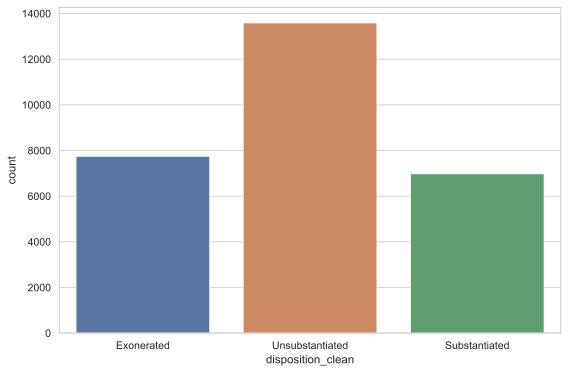

In [121]:
sns.countplot(df['disposition_clean']);

### Explore univariate distribution of features

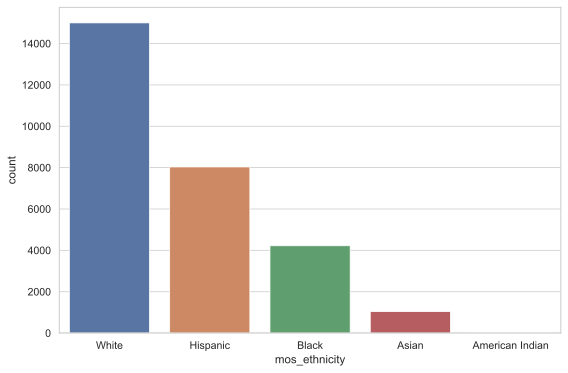

In [122]:
sns.countplot(df['mos_ethnicity']);

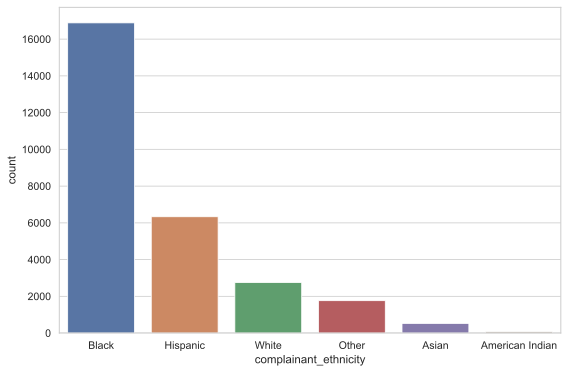

In [123]:
sns.countplot(df['complainant_ethnicity']);

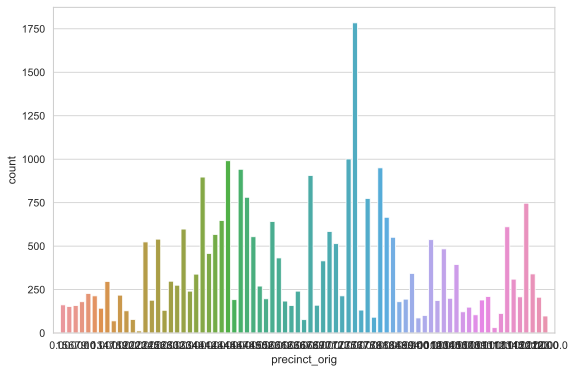

In [124]:
sns.countplot(df['precinct_orig'],orient='h');

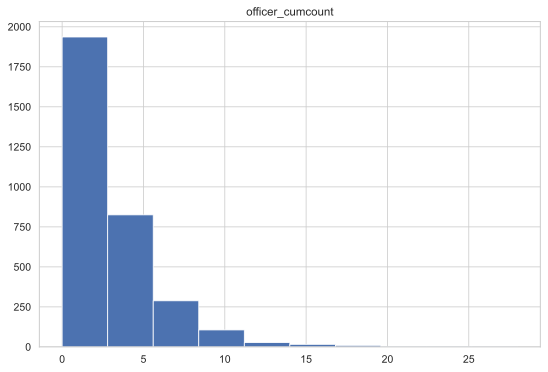

In [125]:
df.groupby('shield_no').agg({'officer_cumcount': 'max'}).hist();

### explore relationships with targets

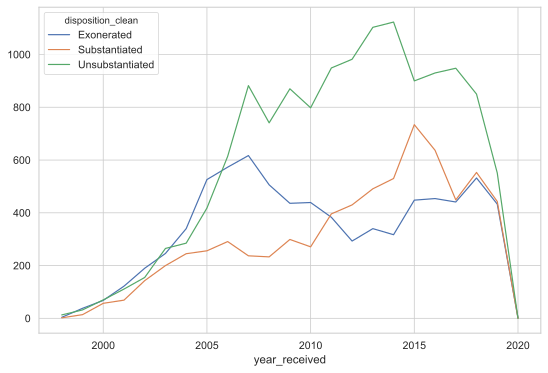

In [126]:
pd.crosstab(index=df['year_received'], columns=df['disposition_clean']).plot();
# impact of stop and frisk shifting exonerated to substantiated? could filter this plot to stop-only records to check
# https://www.nyclu.org/en/stop-and-frisk-data

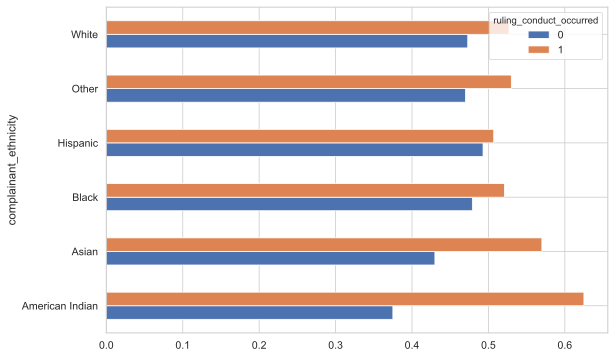

In [134]:
pd.crosstab(index=df['complainant_ethnicity'], columns=df['ruling_conduct_occurred'],
            normalize='index').round(3).plot(kind='barh');

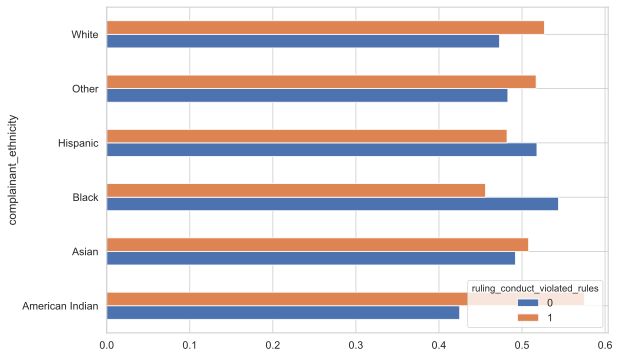

In [128]:
pd.crosstab(index=df_occurred['complainant_ethnicity'], columns=df_occurred['ruling_conduct_violated_rules'],
            normalize='index').round(3).plot(kind='barh');

In [129]:
pd.crosstab(index=df['complainant_ethnicity'], columns=df['fado_type_orig'],
            normalize='index').round(3)

fado_type_orig,Abuse of Authority,Discourtesy,Force,Offensive Language
complainant_ethnicity,,,,
American Indian,0.750,0.125,0.109,0.016
Asian,0.617,0.164,0.181,0.038
Black,0.605,0.134,0.239,0.023
Hispanic,0.570,0.160,0.250,0.020
Other,0.570,0.167,0.241,0.021
White,0.601,0.175,0.200,0.024


## Write dataset to pickle

In [131]:
df.shape

(28318, 52)

In [133]:
df.replace(to_replace=[None], value=np.nan, inplace=True)
with open('processed_data.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)